Codes for the ML modelling 

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


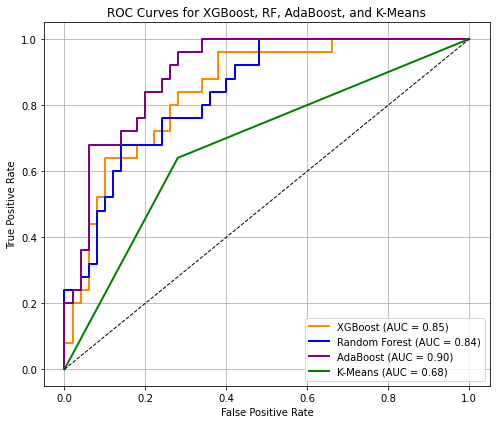

Model Performance (5-fold Cross-Validation)
XGBoost AUC:   0.847
RandomForest:  0.840
AdaBoost AUC:  0.902
K-Means AUC:   0.680


In [3]:

# MACHINE LEARNING MODELS: XGBoost, RF, AdaBoost, K-Means
# with 5-fold Stratified Cross Validation


import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Load training/testing dataset

data = pd.read_csv("Training_Data_B_A.csv")

# Separate predictors and labels
X = data.drop(columns=['Label'])
y = data['Label']

# Standardize predictors 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Define 5-fold stratified cross-validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Define models

xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=3,
    random_state=42
)

ada_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)


# Cross-validation probability predictions

xgb_probs = cross_val_predict(xgb_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
rf_probs = cross_val_predict(rf_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
ada_probs = cross_val_predict(ada_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]


# 5. K-Means (unsupervised baseline)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
kmeans_labels = kmeans.labels_
mapping = {0: int(y[kmeans_labels == 0].mean() > 0.5),
           1: int(y[kmeans_labels == 1].mean() > 0.5)}
kmeans_pred = np.vectorize(mapping.get)(kmeans_labels)


# Compute AUCs

xgb_auc = roc_auc_score(y, xgb_probs)
rf_auc = roc_auc_score(y, rf_probs)
ada_auc = roc_auc_score(y, ada_probs)
kmeans_auc = roc_auc_score(y, kmeans_pred)


#  Plot ROC Curves

plt.figure(figsize=(7,6))
for name, probs, color in [
    ("XGBoost", xgb_probs, 'darkorange'),
    ("Random Forest", rf_probs, 'blue'),
    ("AdaBoost", ada_probs, 'purple'),
    ("K-Means", kmeans_pred, 'green')
]:
    fpr, tpr, _ = roc_curve(y, probs)
    auc = roc_auc_score(y, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})", color=color, lw=2)

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for XGBoost, RF, AdaBoost, and K-Means")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print comparison summary

print("========================================")
print("Model Performance (5-fold Cross-Validation)")
print(f"XGBoost AUC:   {xgb_auc:.3f}")
print(f"RandomForest:  {rf_auc:.3f}")
print(f"AdaBoost AUC:  {ada_auc:.3f}")
print(f"K-Means AUC:   {kmeans_auc:.3f}")
print("========================================")


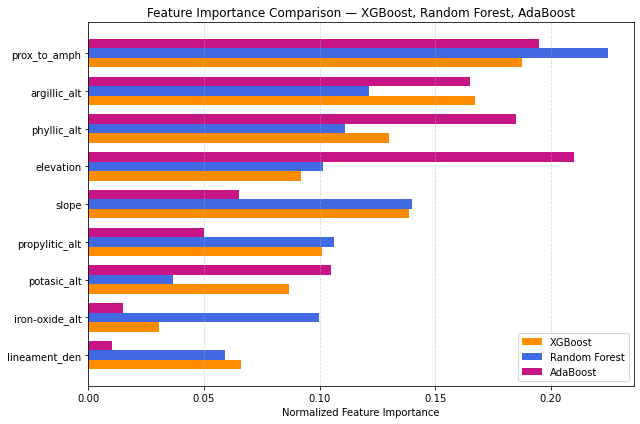

Top-ranked features by mean importance:


,Feature,XGBoost,Random Forest,AdaBoost,Mean
2,prox_to_amph,0.187467,0.224673,0.195,0.202380
5,argillic_alt,0.167406,0.121466,0.165,0.151290
6,phyllic_alt,0.129962,0.110815,0.185,0.141926
1,elevation,0.091829,0.101408,0.210,0.134413
0,slope,0.138892,0.140036,0.065,0.114643
7,propylitic_alt,0.101232,0.106123,0.050,0.085785
4,potasic_alt,0.086789,0.036552,0.105,0.076114
8,iron-oxide_alt,0.030513,0.099851,0.015,0.048454
3,lineament_den,0.065910,0.059076,0.010,0.044995


In [4]:

# FEATURE IMPORTANCE (Horizontal Bar Chart)
# for XGBoost, Random Forest, and AdaBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure models are trained on full dataset
xgb_model.fit(X_scaled, y)
rf_model.fit(X_scaled, y)
ada_model.fit(X_scaled, y)

# -----------------------------------------------
# 1. Extract feature importances
# -----------------------------------------------
feat_names = list(X.columns)

# Get importance arrays
xgb_imp = xgb_model.feature_importances_
rf_imp = rf_model.feature_importances_
ada_imp = ada_model.feature_importances_

# Combine into DataFrame
imp_df = pd.DataFrame({
    'Feature': feat_names,
    'XGBoost': xgb_imp,
    'Random Forest': rf_imp,
    'AdaBoost': ada_imp
})

# Normalize importance scores for fair comparison (0–1 scale)
for col in ['XGBoost', 'Random Forest', 'AdaBoost']:
    imp_df[col] = imp_df[col] / imp_df[col].sum()

# Sort by mean importance across models
imp_df['Mean'] = imp_df[['XGBoost', 'Random Forest', 'AdaBoost']].mean(axis=1)
imp_df = imp_df.sort_values('Mean', ascending=True)


# Plot horizontal bar chart

plt.figure(figsize=(9,6))

# Bar width and positions
bar_width = 0.25
positions = np.arange(len(imp_df))

# Plot bars for each model
plt.barh(positions - bar_width, imp_df['XGBoost'], bar_width, label='XGBoost', color='darkorange')
plt.barh(positions, imp_df['Random Forest'], bar_width, label='Random Forest', color='royalblue')
plt.barh(positions + bar_width, imp_df['AdaBoost'], bar_width, label='AdaBoost', color='mediumvioletred')

# Formatting
plt.yticks(positions, imp_df['Feature'])
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance Comparison — XGBoost, Random Forest, AdaBoost')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Display numeric ranking (optional)

print("Top-ranked features by mean importance:")
display(imp_df.sort_values('Mean', ascending=False).head(10))


In [5]:
### full codes that perform training, testing and prediction

# ===============================================
# PREDICTION PHASE — XGBoost, Random Forest, AdaBoost
# ===============================================

import pandas as pd
import numpy as np

# -----------------------------------------------
# 1. Load training and prediction datasets
# -----------------------------------------------
train = pd.read_csv("Training_Data_B_A.csv")
pred  = pd.read_csv("Prediction_Data_B_B.csv")

# Separate features and label
X = train.drop(columns=['Label'])
y = train['Label']

# Extract coordinates if present in North data
coords = pred[['X', 'Y']] if 'X' in pred.columns else None

# Drop coordinates from predictors
predictor_cols = [c for c in pred.columns if c not in ['X', 'Y']]
Xn = pred[predictor_cols]

# -----------------------------------------------
# 2. Scale predictors (use same scaler as training)
# -----------------------------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xn_scaled = scaler.transform(Xn)

# -----------------------------------------------
# 3. Define and train models
# -----------------------------------------------
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# XGBoost
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb_model.fit(X_scaled, y)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=3,
    random_state=42
)
rf_model.fit(X_scaled, y)

# AdaBoost
ada_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
ada_model.fit(X_scaled, y)

# -----------------------------------------------
# 4. Predict probabilities on North dataset
# -----------------------------------------------
xgb_prob = xgb_model.predict_proba(Xn_scaled)[:, 1]
rf_prob  = rf_model.predict_proba(Xn_scaled)[:, 1]
ada_prob = ada_model.predict_proba(Xn_scaled)[:, 1]

# -----------------------------------------------
# 5. Combine into dataframe
# -----------------------------------------------
pred_df = pd.DataFrame({
    'X': coords['X'] if coords is not None else np.nan,
    'Y': coords['Y'] if coords is not None else np.nan,
    'XGBoost_Prob': xgb_prob,
    'RF_Prob': rf_prob,
    'AdaBoost_Prob': ada_prob
})

# Average (simple ensemble)
pred_df['MPI_Avg'] = pred_df[['XGBoost_Prob', 'RF_Prob', 'AdaBoost_Prob']].mean(axis=1)

# Weighted average (using each model’s AUC from your CV results)
xgb_auc = 0.847
rf_auc  = 0.840
ada_auc = 0.902
total_auc = xgb_auc + rf_auc + ada_auc
pred_df['MPI_Weighted'] = (
    (xgb_auc * pred_df['XGBoost_Prob']) +
    (rf_auc  * pred_df['RF_Prob']) +
    (ada_auc * pred_df['AdaBoost_Prob'])
) / total_auc

# -----------------------------------------------
# 6. Save prediction outputs
# -----------------------------------------------
pred_df.to_csv("North_Model_Predictions_Top3.csv", index=False)
print("✅ Prediction complete — saved as 'North_Model_Predictions_Top3.csv'")
print(pred_df.head())


✅ Prediction complete — saved as 'North_Model_Predictions_Top3.csv'
    X   Y  XGBoost_Prob   RF_Prob  AdaBoost_Prob   MPI_Avg  MPI_Weighted
0 NaN NaN      0.000873  0.005556       0.105292  0.037240      0.038771
1 NaN NaN      0.002453  0.060556       0.107650  0.056886      0.057955
2 NaN NaN      0.002833  0.071944       0.136113  0.070297      0.071691
3 NaN NaN      0.036715  0.148556       0.315178  0.166816      0.170017
4 NaN NaN      0.002773  0.071944       0.146844  0.073854      0.075410


In [6]:

# PREDICTION FOR POINTS (Option B)
# Generates CSV for ArcGIS mapping


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import joblib

# -----------------------------------------------
# 1. Load datasets
# -----------------------------------------------
train = pd.read_csv("Training_Data_B_A.csv")
pred  = pd.read_csv("Prediction_Data_B_B.csv")

# Separate features/labels
X = train.drop(columns=['Label'])
y = train['Label']

# Save coordinate columns if present
coords = pred[['X', 'Y']] if 'X' in pred.columns else None
predictor_cols = [c for c in pred.columns if c not in ['X', 'Y']]
Xn = pred[predictor_cols]


# Standardize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xn_scaled = scaler.transform(Xn)


# Define and train models

xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=3,
    random_state=42
)
ada_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_scaled, y)
rf_model.fit(X_scaled, y)
ada_model.fit(X_scaled, y)

# Predict probabilities on prediction points

xgb_prob = xgb_model.predict_proba(Xn_scaled)[:, 1]
rf_prob  = rf_model.predict_proba(Xn_scaled)[:, 1]
ada_prob = ada_model.predict_proba(Xn_scaled)[:, 1]


# Combine and export

pred_df = pd.DataFrame({
    'X': coords['X'] if coords is not None else np.nan,
    'Y': coords['Y'] if coords is not None else np.nan,
    'XGBoost_Prob': xgb_prob,
    'RF_Prob': rf_prob,
    'AdaBoost_Prob': ada_prob
})

# Weighted ensemble (optional, for reference)
xgb_auc, rf_auc, ada_auc = 0.847, 0.840, 0.902
total_auc = xgb_auc + rf_auc + ada_auc
pred_df['MPI_Weighted'] = (
    (xgb_auc * pred_df['XGBoost_Prob']) +
    (rf_auc  * pred_df['RF_Prob']) +
    (ada_auc * pred_df['AdaBoost_Prob'])
) / total_auc

# Save to CSV for ArcGIS
pred_df.to_csv("North_Model_Probabilities.csv", index=False)
print("✅ Prediction CSV saved as 'North_Model_Probabilities.csv'")
print(pred_df.head())


✅ Prediction CSV saved as 'North_Model_Probabilities.csv'
    X   Y  XGBoost_Prob   RF_Prob  AdaBoost_Prob  MPI_Weighted
0 NaN NaN      0.000873  0.005556       0.105292      0.038771
1 NaN NaN      0.002453  0.060556       0.107650      0.057955
2 NaN NaN      0.002833  0.071944       0.136113      0.071691
3 NaN NaN      0.036715  0.148556       0.315178      0.170017
4 NaN NaN      0.002773  0.071944       0.146844      0.075410


In [7]:
## weight of the predictors based on entropy model

## Entropy weights for predictors

# import the necessary libraries
import pandas as pd
import numpy as np
# define functions for the calculation process of entropy weights
def normalize_matrix(df):  # normalized data function
    # calculate normalized value of decision matrix
    col_sum = df.sum(axis=0)
    normalized_df = df / col_sum
    return normalized_df
def calculate_entropy(normalized_df):  # entropy calculation function
    # calculate entropy from normalized decision matrix
    log_df = np.log(normalized_df + 1e-12)  # Avoid log(0) by adding a very small value
    entropy_matrix = normalized_df.mul(log_df)
    rows, cols = normalized_df.shape
    k = 1 / np.log(rows)
    entropy = -k * entropy_matrix.sum(axis=0)
    return entropy
def calculate_divergence(entropy):   # divergence function
    # Calculate the degree of divergence (1 - entropy)
    divergence_degree = 1 - entropy
    return divergence_degree
def calculate_weights(divergence):  # entropy weights function
    # Calculate the weights by normalizing the divergence values
    weights = divergence / np.sum(divergence)
    return weights
def entropy_weight(data):     # utilizing the functions
    # read the file as a dataframe by defining a variable data
    df = pd.read_csv(data)
    # call the functions
    normalized_df = normalize_matrix(df)
     # print the normalized decision matrix
    print(normalized_df)
    ## continue with calling the remaining functions
    entropy = calculate_entropy(normalized_df)
    divergence = calculate_divergence(entropy)
    weights = calculate_weights(divergence)
    # Combine the results into a DataFrame
    results_df = pd.DataFrame({
        'Entropy': entropy,
        'Degree of divergence': divergence,
        'Weights': weights
    })
    
    return results_df
data = "Prediction_Data_B_B.csv"  
results_df = entropy_weight(data)
# print the results
print("Entropy, Degree of Divergence, and Weights for each criterion:")
print(results_df)


       slope  elevation  prox_to_amph  lineament_den  potasic_alt  \
0   0.009244   0.013181      0.006813       0.020296     0.000000   
1   0.005847   0.013043      0.012269       0.000000     0.000000   
2   0.007623   0.013061      0.013879       0.000000     0.000000   
3   0.020671   0.014092      0.042222       0.032258     0.045383   
4   0.005229   0.013525      0.022181       0.000000     0.000000   
..       ...        ...           ...            ...          ...   
70  0.037161   0.012098      0.009934       0.017269     0.000000   
71  0.011246   0.013456      0.016841       0.000000     0.000000   
72  0.007623   0.012992      0.014044       0.000000     0.000000   
73  0.001849   0.013817      0.026029       0.016204     0.000000   
74  0.005547   0.013765      0.028426       0.036860     0.000000   

    argillic_alt  phyllic_alt  propylitic_alt  iron-oxide_alt  
0       0.013577     0.013535        0.013576        0.013432  
1       0.013787     0.013449        0.0135

In [9]:
results_df.to_csv('Entropyweights_Predictors.csv', index = False)